In [1]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
from graphmodels.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
import pandas as pd
import plotly.express as px
from sklearn.metrics import r2_score
from database import select_dataset

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]#.fillna(0)
    return X


def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='GGI_code', values='Value')

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y

In [27]:
df = pd.read_csv('models/Hermen/data/GY_GE_GU_GM_GP_GT.csv')
pop = select_dataset('population')
data_dict = df_to_dict(pivot(df))
data_dict['Pop'] = pop.set_index(['Area', 'Year'])['Value']
data_dict['OEi'] = data_dict['OEi'].reset_index(level='Item', drop='True').dropna()
data_dict['MYi'] = data_dict['MYi']#.dropna()#.reset_index(level='Item', drop='True').dropna()

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
from models.Hermen.model_GE3 import GE3_models
res = []
for model_name, model in GE3_models.items():
    print(model_name)
    X, y = get_X_y_from_data(model, data_dict)
    
    print(score_model(model, X, y))


TMi_model
    r2  correlation          rmse Variable
0  1.0          1.0  1.053919e-15      TMi
M_xi_model
    r2  correlation          rmse Variable
0  1.0          1.0  7.382541e-16     M_Ti
1  1.0          1.0  8.550658e-16    M_LPi
2  1.0          1.0  5.858794e-16    M_ASi
TMP_CO2eq_model
         r2  correlation       rmse   Variable
0  0.999997     0.999999  17.156806  TMP_CO2eq
TMT_CO2eq_model
         r2  correlation          rmse   Variable
0  0.999992     0.999997  2.536710e-05       E_Ti
1  1.000000     1.000000  1.259033e-08    E_TCH4i
2  0.999997     0.999999  2.438036e+00  TMT_CO2eq
TMA_CO2eq_model
         r2  correlation      rmse   Variable
0  0.999993          1.0  1.748403  TMA_CO2eq
TEE_CO2eq_model
    r2  correlation          rmse   Variable
0  1.0          1.0  4.388695e-10  TEE_CO2eq
FE_CO2eq_model
         r2  correlation         rmse  Variable
0  0.999987     0.999994  2401.629787  FE_CO2eq
GE3_partial_model
Empty DataFrame
Columns: []
Index: []
GE3_model
    

In [29]:
%time GE3 = model.run(X)#['GE3']

CPU times: user 369 ms, sys: 11 ms, total: 380 ms
Wall time: 254 ms


# Animal

In [61]:
#livestock_df = select_dataset('livestock')
livestock_df = pd.read_csv('models/Hermen/data/QL.csv', index_col=0)

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
test = livestock_df.copy()#.groupby(['Area', 'Year', 'Variable', 'emi_item', 'Item'])#.sum().reset_index()

def pivot(df):
    return df.pivot(index=['Area', 'Year','Item', 'emi_item'], columns='GGI_code', values='Value')

test = df_to_dict(pivot(test))
test['TAi'] = data_dict['TAi']
test['PTTAi'] = test['PTTAi'].reset_index(level='Item', drop=True).rename_axis(index={'emi_item': 'Item'}).dropna()

In [65]:
__author__ = 'Hermen'
__status__ = 'Pending Validation'

"""
TO DO.
"""
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs

# Conversions
GWPN2O = 310
GWPCH4 = 21
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6

TAi_nodes = {'FPi': {'type': 'input',
                     'unit': 'tonnes',
                     'name': 'Production'},
             'AYi': {'type': 'input',
                     'unit': 'tonnes/head',
                     'name': 'Vector of animal yields'},
             'ANPi': {'type': 'variable',
                      'unit': 'head',
                      'name': 'Vector animals needed for production',
                      'computation': lambda FPi, AYi, **kwargs: FPi / AYi
                      },
             'PTTAi': {'type': 'parameter',
                       'unit': '1',
                       'name': 'vector production-to-total animals ratio',
                       },
             'TAi': {'type': 'output',
                     'unit': 'head',
                     'name': 'Total animal population',
                     'computation': lambda ANPi, PTTAi, **kwargs: PTTAi * ANPi.groupby(level=['Area', 'Year', 'emi_item']).sum().rename_axis(index={"emi_item": 'Item'})
                     },
             }

TMi_nodes = {'TAi': {'type': 'input', 'unit': 'head', 'name': 'Total animal population'},
             'MYi': {'type': 'input', 'unit': 'kgN/head', 'name': 'Manure yields'},
             'TMi': {'type': 'output',
                     'unit': 'kgN',
                     'name': 'Total Manure (N content)',
                     'computation': lambda TAi, MYi, **kwargs: TAi * MYi
                     }
             }

M_xi_nodes = {'TMi': {'type': 'input',
                              'unit': 'kgN',
                              'name': 'Total Manure (N content)'},
              'MM_ASi': {'type': 'input',
                         'unit': '1',
                         'name': '% Manure applied to soils'},
              'MM_LPi': {'type': 'input',
                         'unit': '1',
                         'name': '% Manure left on pasture'},
              'MM_Ti': {'type': 'input',
                        'unit': '1',
                        'name': '% Manure left on treated'},
              'M_Ti': {'type': 'output',
                       'unit': 'kgN',
                       'name': 'Manure treated (N content)',
                       'computation': lambda MM_Ti, TMi, **kwargs: MM_Ti * TMi

                       },
              'M_LPi': {'type': 'output',
                        'unit': 'kg',
                        'name': 'Manure left on pasture (N content)',
                        'computation': lambda MM_LPi, TMi, **kwargs: MM_LPi * TMi

                        },
              'M_ASi': {'type': 'output',
                        'unit': 'kgN',
                        'name': 'Manure applied to soils (N content)',
                        'computation': lambda MM_ASi, TMi, **kwargs: MM_ASi * TMi

                        }
              }

TMP_CO2eq_nodes = {'M_LPi': {'type': 'input',
                             'unit': 'kg',
                             'name': 'Manure left on pasture (N content)'},
                   'EF_Li': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure on pasture)'
                             },
                   'TMP_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure on pasture)',
                                 'computation': lambda M_LPi, EF_Li, **kwargs: kg_to_Gg * N2ON_to_NO2 * GWPN2O * (M_LPi * EF_Li)
                                 }
                   }

TMT_CO2eq_nodes = {'M_Ti': {'type': 'input',
                            'unit': 'kgN',
                            'name': 'Manure treated (N content)',
                            },
                   'EF_Ti': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure management)'},
                   'EF_CH4Ti': {'type': 'parameter',
                                'unit': 'kg/head',
                                'name': 'Implied emission factor for CH4 (Manure management)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'E_Ti': {'type': 'variable',
                            'unit': 'gigagrams',
                            'name': 'Emissions (N2O) (Manure management)',
                            'computation': lambda EF_Ti, M_Ti, **kwargs: N2ON_to_NO2 * kg_to_Gg * (EF_Ti * M_Ti)
                            },
                   'E_TCH4i': {'type': 'variable',
                               'unit': 'gigagrams',
                               'name': 'Emissions (CH4) (Manure management)',
                               'computation': lambda EF_CH4Ti, TAi, **kwargs: kg_to_Gg * (EF_CH4Ti * TAi)
                               },
                   'TMT_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure management)',
                                 'computation': lambda E_Ti, E_TCH4i, **kwargs: E_Ti * GWPN2O + E_TCH4i * GWPCH4
                                 }}

TMA_CO2eq_nodes = {'M_ASi': {'type': 'input',
                             'unit': 'kgN',
                             'name': 'Manure applied to soils (N content)',
                             },
                   'EF_ASi': {'type': 'parameter',
                              'unit': 'kg N2O-N/kg N',
                              'name': 'Implied emission factor for N2O (Manure applied)'},
                   'TMA_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure applied)',
                                 'computation': lambda EF_ASi, M_ASi, **kwargs: GWPN2O * N2ON_to_NO2 * kg_to_Gg * (EF_ASi * M_ASi)
                                 }
                   }

TEE_CO2eq_nodes = {'EF_EEi': {'type': 'input',
                              'unit': 'kg CH4 / head',
                              'name': 'Implied emission factor for CH4 (Enteric)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'TEE_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Enteric)',
                                 'computation': lambda TAi, EF_EEi, **kwargs: kg_to_Gg * GWPCH4 * (TAi * EF_EEi)
                                 }
                   }

FE_CO2eq_nodes = {
    'IN_F': {'type': 'input',
             'unit': 'kg',
             'name': 'Agricultural Use in nutrients',
             },
    'EF_F': {'type': 'parameter',
             'unit': 'kg N2O-N/kg N',
             'name': 'Implied emission factor for N2O (Synthetic fertilizers)'},
    'FE_CO2eq': {'type': 'output',
                 'unit': 'gigagrams (CO2eq)',
                 'name': 'Emissions (CO2eq) (Synthetic fertilizers)',
                 'computation': lambda EF_F, IN_F, **kwargs: GWPN2O * N2ON_to_NO2 * kg_to_Gg * (EF_F * IN_F)
                 }
}

GE3_nodes = {'Pop': {'type': 'input', 'unit': '1000 persons', 'name': 'Total population'},
             'TEE_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Enteric)'},
             'TMT_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure management)'},
             'TMA_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure applied)'},
             'TMP_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure on pasture)'},
             'FE_CO2eq': {'type': 'input',
                          'unit': 'gigagrams (CO2eq)',
                          'name': 'Emissions (CO2eq) (Synthetic fertilizers)'},
             'OEi': {'type': 'input',
                     'unit': 'gigagrams (CO2eq)',
                     'name': 'Vector of other emissions'},
             'GE3': {'type': 'output',
                     'unit': 'gigagrams (CO2eq) / capita',
                     'name': 'Ratio of non-CO2 emissions in agriculture to population',
                     'computation': lambda OEi, TEE_CO2eq, TMT_CO2eq, TMP_CO2eq, TMA_CO2eq, FE_CO2eq, Pop, **kwargs: (OEi + (TEE_CO2eq + TMT_CO2eq + TMP_CO2eq + TMA_CO2eq + FE_CO2eq).groupby(level=['Area', 'Year']).sum()) / (Pop * 1e3)}}


nodes = concatenate_graph_specs(
    [GE3_nodes, TEE_CO2eq_nodes, TMA_CO2eq_nodes, TMT_CO2eq_nodes, TMP_CO2eq_nodes, FE_CO2eq_nodes, M_xi_nodes, TMi_nodes, TAi_nodes])

# models
TAi_model = GraphModel(TAi_nodes)
TMi_model = GraphModel(TMi_nodes)
M_xi_model = GraphModel(M_xi_nodes)
TMP_CO2eq_model = GraphModel(TMP_CO2eq_nodes)
TMT_CO2eq_model = GraphModel(TMT_CO2eq_nodes)
TMA_CO2eq_model = GraphModel(TMA_CO2eq_nodes)
TEE_CO2eq_model = GraphModel(TEE_CO2eq_nodes)
FE_CO2eq_model = GraphModel(FE_CO2eq_nodes)
GE3_partial_model = GraphModel(GE3_nodes)

GE3_model = GraphModel(nodes)

GE3_models = {'TMi_model': TMi_model,
              'TAi_model': TAi_model,
              'M_xi_model': M_xi_model,
              'TMP_CO2eq_model': TMP_CO2eq_model,
              'TMT_CO2eq_model': TMT_CO2eq_model,
              'TMA_CO2eq_model': TMA_CO2eq_model,
              'TEE_CO2eq_model': TEE_CO2eq_model,
              'FE_CO2eq_model': FE_CO2eq_model,
              'GE3_partial_model': GE3_partial_model,
              'GE3_model': GE3_model
              }


test_mod = GraphModel( concatenate_graph_specs([TMi_nodes, TAi_nodes]))


In [66]:
data_dict.update(test)


In [67]:
X, y = get_X_y_from_data(TAi_model, data_dict)

res = TAi_model.run(X)

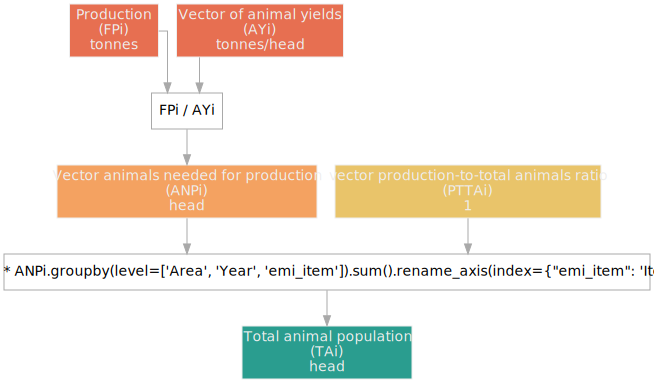

In [68]:
TAi_model.draw()

In [ ]:
res = []
for model_name, model in GE3_models.items():
    print(model_name)
    X, y = get_X_y_from_data(model, data_dict)
    #%time res = model.run(X)
    print(score_model(model, X, y))

    print()


TMi_model
    r2  correlation          rmse Variable
0  1.0          1.0  1.053919e-15      TMi

TAi_model


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/multi.py:3585: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  uniq_tuples = lib.fast_unique_multiple([self._values, other._values], sort=sort)


    r2  correlation          rmse Variable
0  1.0          1.0  2.075621e+08     ANPi
1  1.0          1.0  1.660086e+09      TAi

M_xi_model
    r2  correlation          rmse Variable
0  1.0          1.0  7.382541e-16     M_Ti
1  1.0          1.0  8.550658e-16    M_LPi
2  1.0          1.0  5.858794e-16    M_ASi

TMP_CO2eq_model
         r2  correlation       rmse   Variable
0  0.999997     0.999999  17.156806  TMP_CO2eq

TMT_CO2eq_model
         r2  correlation          rmse   Variable
0  0.999992     0.999997  2.536710e-05       E_Ti
1  1.000000     1.000000  1.259033e-08    E_TCH4i
2  0.999997     0.999999  2.438036e+00  TMT_CO2eq

TMA_CO2eq_model
         r2  correlation      rmse   Variable
0  0.999993          1.0  1.748403  TMA_CO2eq

TEE_CO2eq_model
    r2  correlation          rmse   Variable
0  1.0          1.0  4.388695e-10  TEE_CO2eq

FE_CO2eq_model
         r2  correlation         rmse  Variable
0  0.999987     0.999994  2401.629787  FE_CO2eq

GE3_partial_model
Empty DataFr

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/multi.py:3585: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  uniq_tuples = lib.fast_unique_multiple([self._values, other._values], sort=sort)
